# Loss function test

## Color Saliency Loss

In [1]:
%matplotlib inline

In [2]:
from typing import Tuple

In [3]:
import torch
import torch.nn as nn
import torchvision.transforms as T

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [4]:
def plot(imgs, with_orig=True, row_title=None, fw=15, fh=10, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False, figsize=(fw, fh))
    for row_idx, row in enumerate(imgs):
        row = [orig_img] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [106]:
class SaliencyLoss(nn.Module):
    """Implementation of the colorfulness metric as the saliency loss.
    The smaller the value, the less colorful the image.
    Reference: https://infoscience.epfl.ch/record/33994/files/HaslerS03.pdf
    """

    def __init__(self):
        super(SaliencyLoss, self).__init__()

    def forward(self, adv_patch: torch.Tensor) -> torch.Tensor:
        """
        Args:
            adv_patch: Float Tensor of shape [C, H, W] where C=3 (R, G, B channels)
        """
        assert adv_patch.shape[0] == 3
        r, g, b = adv_patch
        rg = r - g
        yb = 0.5 * (r + g) - b

        mu_rg, sigma_rg = torch.mean(rg), torch.std(rg)
        mu_yb, sigma_yb = torch.mean(yb), torch.std(yb)
        sl = torch.sqrt(sigma_rg**2 + sigma_yb**2) + (0.3 * torch.sqrt(mu_rg**2 + mu_yb**2))
        return sl / torch.numel(adv_patch)

In [107]:
x = torch.randn(3, 224, 224)

In [108]:
loss_saliency = SaliencyLoss()
loss_saliency(x)

tensor(1.2460e-05)

In [5]:
low_color_img = Image.open("images/low_color.png", 'r')
high_color_img = Image.open("images/high_color.png", 'r')

low_color_img = low_color_img.resize((224, 224))
high_color_img = high_color_img.resize((224, 224))
low_color_img = np.asarray(low_color_img)[:, :, :3]
high_color_img = np.asarray(high_color_img)[:, :, :3]

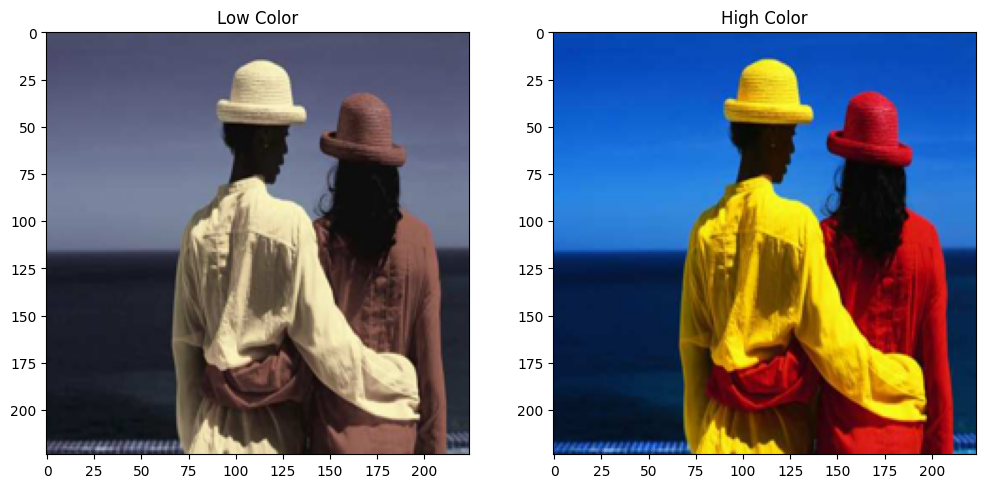

In [26]:
fig, ax = plt.subplots(1,2, figsize=(12, 10))
ax[0].imshow(low_color_img)
ax[1].imshow(high_color_img)
ax[0].set_title("Low Color")
ax[1].set_title("High Color")
plt.show()

In [40]:
low_color_tensor = torch.from_numpy(low_color_img.copy()).float().permute((2, 0, 1))
low_color_tensor.requires_grad = True

high_color_tensor = torch.from_numpy(high_color_img.copy()).float().permute((2, 0, 1))
high_color_tensor.requires_grad = True

# Note the first value must be smaller than the second value
loss_saliency(low_color_tensor), loss_saliency(high_color_tensor)

(tensor(0.0002, grad_fn=<DivBackward0>),
 tensor(0.0010, grad_fn=<DivBackward0>))

In [9]:
loss_s.backward()  # loss is differentiable as well

## Total Variation Loss

In [10]:
class TotalVariationLoss(nn.Module):
    """TotalVariationLoss: calculates the total variation of a patch.
    Module providing the functionality necessary to calculate the total vatiation (TV) of an adversarial patch.
    Reference: https://en.wikipedia.org/wiki/Total_variation
    """

    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, adv_patch: torch.Tensor) -> torch.Tensor:
        """
        Args:
            adv_patch: Tensor of shape [C, H, W] 
        """
        # calc diff in patch rows
        tvcomp_r = torch.sum(torch.abs(adv_patch[:, :, 1:] - adv_patch[:, :, :-1]+0.000001), dim=0)
        tvcomp_r = torch.sum(torch.sum(tvcomp_r, dim=0), dim=0)
        # calc diff in patch columns
        tvcomp_c = torch.sum(torch.abs(adv_patch[:, 1:, :] - adv_patch[:, :-1, :]+0.000001), dim=0)
        tvcomp_c = torch.sum(torch.sum(tvcomp_c, dim=0), dim=0)
        tv = tvcomp_r + tvcomp_c
        return tv / torch.numel(adv_patch)

In [13]:
adv_patch_grey = torch.full((3, 224,224), 0.5)
adv_patch_rand = torch.randn(3, 224, 224)

In [14]:
tv_loss = TotalVariationLoss()
tv_loss(adv_patch_grey), tv_loss(adv_patch_rand)  # note the grey patch must have a lower tv loss

(tensor(1.9911e-06), tensor(2.2468))

## Non Printability Score Loss

In [87]:
class NPSLoss(nn.Module):
    """NMSLoss: calculates the non-printability-score loss of a patch.
    Module providing the functionality necessary to calculate the non-printability score (NMS) of an adversarial patch.
    However, a summation of the differences is used instead of the total product to calc the NPSLoss
    Reference: https://users.ece.cmu.edu/~lbauer/papers/2016/ccs2016-face-recognition.pdf
    
    Args: 
        triplet_scores_fpath: str, path to csv file with RGB triplets sep by commas in newlines
        size: Tuple[int, int], Tuple with width, height of the patch
    """

    def __init__(self, triplet_scores_fpath: str, size: Tuple[int, int]):
        super(NPSLoss, self).__init__()
        self.printability_array = nn.Parameter(self.get_printability_array(triplet_scores_fpath, size), requires_grad=False)

    def forward(self, adv_patch):
        # calculate euclidian distance between colors in patch and colors in printability_array 
        # square root of sum of squared difference
        color_dist = (adv_patch - self.printability_array + 0.000001)
        color_dist = color_dist ** 2
        color_dist = torch.sum(color_dist, 1) + 0.000001
        color_dist = torch.sqrt(color_dist)
        # use the min distance
        color_dist_prod = torch.min(color_dist, 0)[0]
        # calculate the nps by summing over all pixels
        nps_score = torch.sum(color_dist_prod, 0)
        nps_score = torch.sum(nps_score, 0)
        return nps_score / torch.numel(adv_patch)
    
    def get_printability_array(self, triplet_scores_fpath: str, size: Tuple[int, int]) -> torch.Tensor:
        """
        Get printability tensor array holding the rgb triplets (range [0,1]) loaded from triplet_scores_fpath
        Args: 
            triplet_scores_fpath: str, path to csv file with RGB triplets sep by commas in newlines
            size: Tuple[int, int], Tuple with width, height of the patch
        """
        ref_triplet_list = []
        # read in reference printability triplets into a list
        with open(triplet_scores_fpath) as f:
            for line in f:
                ref_triplet_list.append(line.strip().split(","))

        w, h = size
        printability_array = []
        for ref_triplet in ref_triplet_list:
            r, g, b = map(float, ref_triplet)
            ref_tensor_img = torch.stack([torch.full((h, w), r),
                                          torch.full((h, w), g),
                                          torch.full((h, w), b)])
            printability_array.append(ref_tensor_img.float())
        return torch.stack(printability_array)

    def get_printability_array_old(self, triplet_scores_fpath: str, patch_side_len: int) -> torch.Tensor:
        """
        Get printability tensor array holding the rgb triplets (range [0,1]) loaded from triplet_scores_fpath
        Args: 
            triplet_scores_fpath: str, path to csv file with RGB triplets sep by commas in newlines
            patch_side_len: int, length of the sides of the patch
        """
        side = patch_side_len
        ref_triplet_list = []

        # read in reference printability triplets and put them in a list
        with open(triplet_scores_fpath) as f:
            for line in f:
                ref_triplet_list.append(line.strip().split(","))

        printability_array = []
        for ref_triplet in ref_triplet_list:
            ref_imgs = []
            r, g, b = ref_triplet
            ref_imgs.append(np.full((side, side), r))
            ref_imgs.append(np.full((side, side), g))
            ref_imgs.append(np.full((side, side), b))
            printability_array.append(ref_imgs)

        printability_array = np.asarray(printability_array)
        printability_array = np.float32(printability_array)
        pa = torch.from_numpy(printability_array)
        print(pa.shape, pa.dtype)
        return pa

In [88]:
nps_loss = NPSLoss("30_rgb_triplets.csv", (224, 224))

In [90]:
adv_patch_grey = torch.full((3, 224,224), 0.5)
adv_patch_rand = torch.randn(3, 224, 224)

# the grey patch must have lower nps score as it more printable than the rand noise patch
nps_loss(adv_patch_grey), nps_loss(adv_patch_rand)

(tensor(0.0384), tensor(0.4600))

## Noise addition and contrast reduction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


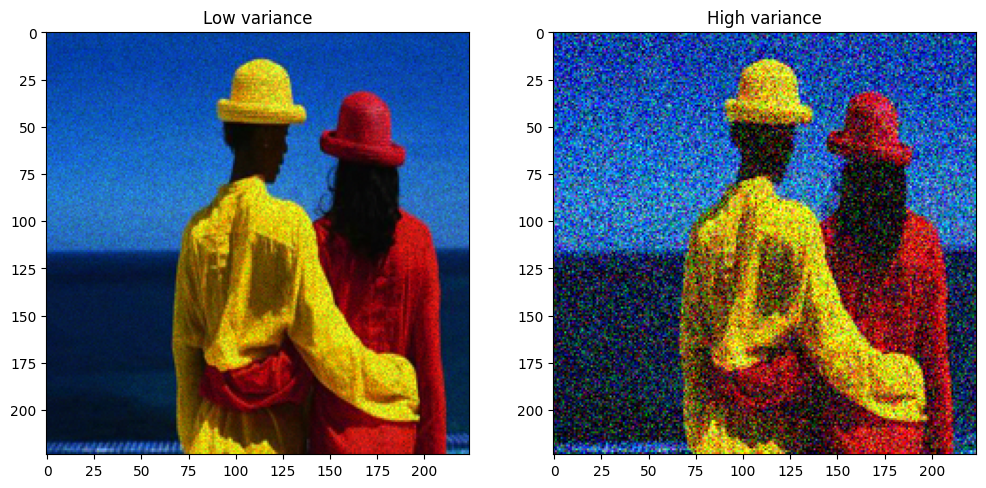

In [32]:
h, w, c = high_color_img.shape
nprn = np.random.normal
rcless = high_color_img * nprn(0.9, 0.1, (h, w, c)) + nprn(0, 0.001, (h, w, c))
rcmore = high_color_img * nprn(0.9, 0.1, (h, w, c)) + nprn(0, 50, (h, w, c))

fig, ax = plt.subplots(1, 2, figsize=(12, 10))
ax[0].imshow(rcless / 255.)
ax[1].imshow(rcmore / 255.)
ax[0].set_title("Low variance")
ax[1].set_title("High variance")
plt.show()


In [21]:
h, w, c = high_color_img.shape
nprn = np.random.normal

rc05 = high_color_img * nprn(0.5, 0.1, (h, w, c)) + nprn(0, 0.01, (h, w, c))
rc06 = high_color_img * nprn(0.6, 0.1, (h, w, c)) + nprn(0, 0.01, (h, w, c))
rc07 = high_color_img * nprn(0.7, 0.1, (h, w, c)) + nprn(0, 0.01, (h, w, c))
rc08 = high_color_img * nprn(0.8, 0.1, (h, w, c)) + nprn(0, 0.01, (h, w, c))
rc09 = high_color_img * nprn(0.9, 0.1, (h, w, c)) + nprn(0, 0.01, (h, w, c))

In [22]:
img_list = [high_color_img, rc09, rc08, rc07, rc06, rc05]
title_list = ["High color img", "reduced_color 0.9", "reduced_color 0.8", "reduced_color 0.7", "reduced_color 0.6", "reduced_color 0.5"]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


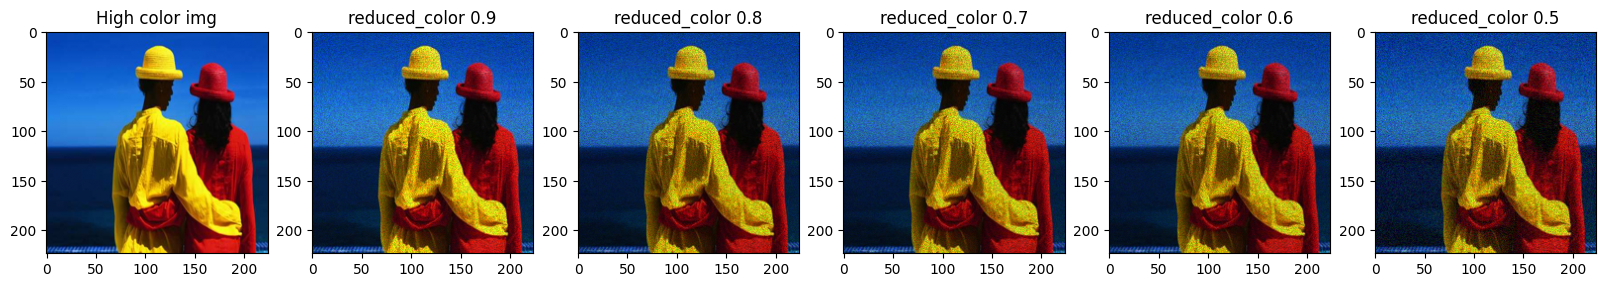

In [23]:
assert len(img_list) == len(title_list) 
fig, ax = plt.subplots(1, len(img_list), figsize=(20, 10))
for i, (img, title) in enumerate(zip(img_list, title_list)):
    ax[i].imshow(img / 255.)
    ax[i].set_title(title)
plt.show()

## Plot random perspective transforms

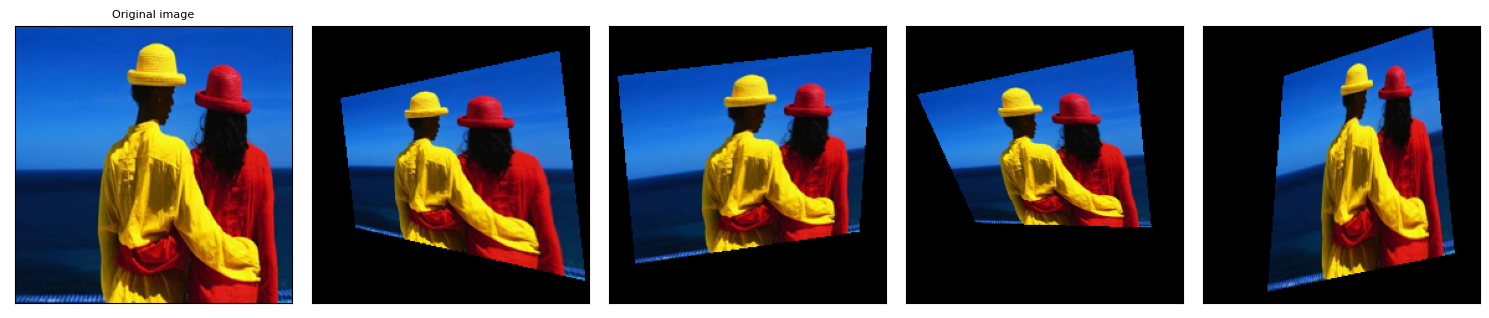

In [32]:
orig_img = Image.fromarray(high_color_img)
perspective_transformer = T.RandomPerspective(distortion_scale=0.6, p=1.0)
perspective_imgs = [perspective_transformer(orig_img) for _ in range(4)]
plot(perspective_imgs)

In [85]:
class PerspectiveTransform(nn.Module):
    """PerspectiveTransform as a module for differentiation
    https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
    """

    def __init__(self):
        super(PerspectiveTransform, self).__init__()
        self.trp = T.RandomPerspective(distortion_scale=0.9, p=1.0)

    def forward(self, adv_patch: torch.Tensor) -> torch.Tensor:
        """
        Args:
            adv_patch: Float Tensor of shape [B, C, H, W] where C=3 (R, G, B channels)
        """
        trans = self.trp(adv_patch)
        return trans

In [92]:
trans = PerspectiveTransform()
orig_image_tensor = T.ToTensor()(orig_img)  #  tensor(0.) tensor(1.)
ic, ih, iw = orig_image_tensor.shape
orig_image_tensor = orig_image_tensor.unsqueeze(0).repeat(2, 1, 1, 1)  # torch.Size([2, 3, 224, 224])
orig_image_tensor = orig_image_tensor.unsqueeze(0).repeat(2, 1, 1, 1, 1)  # torch.Size([2, 2, 3, 224, 224])

orig_image_tensor = orig_image_tensor.reshape(-1, ic, ih, iw)  # torch.Size([4, 3, 224, 224])
trans_image_tensor = trans(orig_image_tensor)  # torch.Size([4, 3, 224, 224])

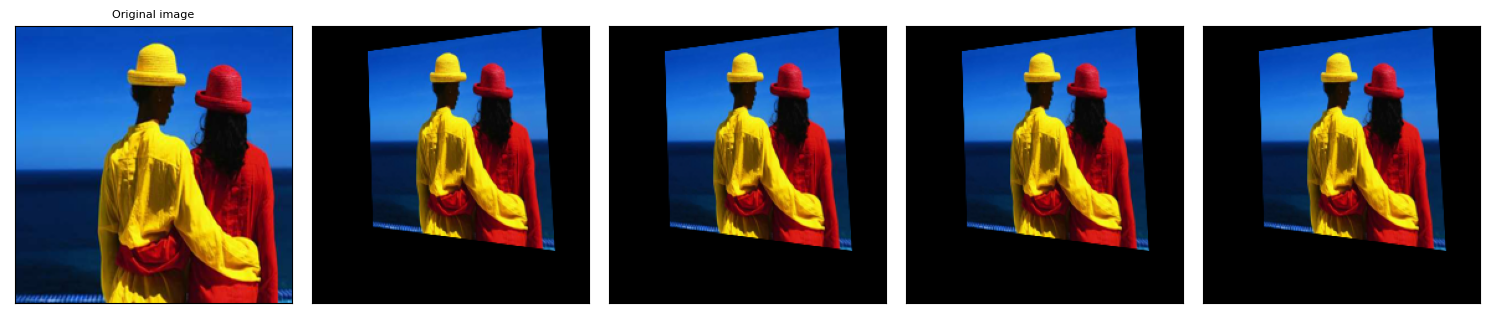

In [93]:
plot([T.ToPILImage()(img) for img in trans_image_tensor])